# 네이버 뉴스 기사 분석

## 관련 라이브러리 import
- https://github.com/lovit/customized_konlpy
- pip install customized_konlpy
- pip install textrankr

## 기본과제_LDA분석.0420ipynb

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import re
import gensim 
#import mglearn
import numpy as np
import pandas as pd
import os
from konlpy.utils import pprint
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.gensim
import pyLDAvis.sklearn
import collections
from konlpy.tag import Kkma

from ckonlpy.tag import Twitter

from gensim.models.word2vec import Word2Vec
#from eunjeon import Mecab  # KoNLPy style mecab wrapper
import copy
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

from textrankr import TextRank

# 명사인식
import soynlp
from soynlp.utils import DoublespaceLineCorpus
from soynlp.noun import LRNounExtractor_v2

plt.rc('font', family='NanumBarunGothicOTF')

import warnings
warnings.filterwarnings('ignore')

# 전처리되 ㄴ데이터 불러오기 from 

In [25]:
dir_path = 'D:/2020기본과제/naver/data/'

In [26]:
df= pd.read_pickle(dir_path + 'df_processed.pkl')
df.head()
df.shape

,date,source,title,contents,length_sentence,num_words,num_uniq_words,년도,월,요일
0,2018-06-29,조선비즈,"뷰노, AI 기반 심정지 예측 소프트웨어 유효성 입증",국내 최초의 의료 인공지능 AI 스타트업 뷰노 VUNO 개발한 AI 기반 심정지 예...,1472,301,253,2018,6,4
1,2018-06-29,eTimesinternet Co,심정지 예측 85% AI 시스템 개발..내년 상용화 전망,뷰노메드 DEWS 시간 정확도로 심정지를 예측하는 인공지능 시스템이 개발됐다 기존 ...,995,208,180,2018,6,4
2,2018-06-29,한경닷컴,"뷰노 심정지 예측 AI, 임상 연구 미국심장협회지에 게재",임유 기자 의료용 인공지능 AI 전문기업 뷰노 대표 이예하 자사가 개발한 AI 기반...,1200,253,212,2018,6,4
3,2018-06-29,MoneyToday,롯데제과의 AI 실험 '가속도'…과자도 파이도 변신,머니투데이 김소연 기자 롯데제과가 식품업계 최초로 도입한 인공지능 AI 로봇 쵸니봇...,1631,341,296,2018,6,4
4,2018-06-26,edaily,"구글 AI 책임자 ""모두를 위한 AI"" 강조..AI 대중화 시대",제프 구글AI 총괄 구글 제품 뿐만 아니라 외부 기관 기업도 AI 필요 구글은 이들...,1985,472,360,2018,6,1


(165260, 10)

In [27]:
df = df.rename(columns={'date':'신고일시', 'contents':'신고내용'})

## 4. Corpus 생성 (corpus,  말뭉치는 리스트형태로)

In [28]:
corpus = [] 
for fn in df['신고내용'] :  # (text를 반복문으로 불러 읽어 리스트로 다시 기록)
    corpus.append(fn)
    
corpus = pd.DataFrame(corpus) # 데이터프레임 저장
corpus.columns = ['신고내용']

corpus_fname = dir_path + '../working/corpus.txt'
corpus.to_csv(dir_path + '../working/corpus.txt', sep=" ", header=None) # 필요시 저장

corpus.head()

,신고내용
0,국내 최초의 의료 인공지능 AI 스타트업 뷰노 VUNO 개발한 AI 기반 심정지 예...
1,뷰노메드 DEWS 시간 정확도로 심정지를 예측하는 인공지능 시스템이 개발됐다 기존 ...
2,임유 기자 의료용 인공지능 AI 전문기업 뷰노 대표 이예하 자사가 개발한 AI 기반...
3,머니투데이 김소연 기자 롯데제과가 식품업계 최초로 도입한 인공지능 AI 로봇 쵸니봇...
4,제프 구글AI 총괄 구글 제품 뿐만 아니라 외부 기관 기업도 AI 필요 구글은 이들...


### 3.4 명사를 추출하여 명사추출기(twitter.dictionary)에 추가
3.1 min_num_of_features를 5, 10, 15, 20으로 해보고 가장 좋은 것을 select한 결과

In [3]:
from soynlp.utils import DoublespaceLineCorpus
from soynlp.noun import LRNounExtractor_v2

In [6]:
sents = DoublespaceLineCorpus(corpus_fname, iter_sent=True) # 명사인식을 위한 메소드 내부구조 
noun_extractor = LRNounExtractor_v2(verbose=True, max_left_length=10, min_num_of_features = 15) # 명사 인식기 생성
noun_extractor.train(sents) # 명사 인식기 학습
nouns = noun_extractor.extract(min_noun_frequency=5) # 명사추출, dictionary 자료 형태임

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=3929, neg=2321, common=107
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 928975 from 165260 sents. mem=0.784 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=45429264, mem=2.482 Gb
[Noun Extractor] batch prediction was completed for 208919 words
[Noun Extractor] checked compounds. discovered 199689 compounds
[Noun Extractor] postprocessing detaching_features : 74274 -> 73645
[Noun Extractor] postprocessing ignore_features : 73645 -> 73367
[Noun Extractor] postprocessing ignore_NJ : 73367 -> 72644
[Noun Extractor] 72644 nouns (199689 compounds) with min frequency=5
[Noun Extractor] flushing was done. mem=2.817 Gb                    
[Noun Extractor] 83.36 % eojeols are covered


### 3.5 한 글자 제거하고 따옴표 등 정리
필요시 파일로 저장, 잘못 인식된 단어가 많으므로 수작업을 통해 필요한 단어 정리 필요

In [7]:
noun_list = list(nouns.keys()) # 사전형자료를 리스트자료로 변환
print('(1) 추출된 명사 총 개수 : ', len(noun_list))

single_letter_list =[]

for word in noun_list:
    if len(word) == 1:
       single_letter_list.append(word)

print('(2) 추출된 한 글자 명사 총 개수 : ', len(single_letter_list))
print('(3) 두글자 이상 명사 총 개수 : ' , len(noun_list) - len(single_letter_list))

noun_list = list(set(noun_list) - set(single_letter_list))

(1) 추출된 명사 총 개수 :  72644
(2) 추출된 한 글자 명사 총 개수 :  408
(3) 두글자 이상 명사 총 개수 :  72236


# 자료 재 구성

## 1. 따옴표 제거하여 재정리

In [8]:
noun_list_new =[]

for i in noun_list :
    noun_list_new.append(i.replace('"',""))
    
len(noun_list_new)
','.join(noun_list_new)[0:500]

noun_list = noun_list_new

72236

'개미들,오늘습관,성상교세포,불안정,간해독,공정화,장보고,부산시청,수치화,확산세,알파메딕,연구,책임연구원팀,서울시내,해먹어,S사,소비력,트랜스포메이션,정형,면책제도,크릭,계획생산,춘향,음란물,HOCl,특별구제계정,트리코모나스,자동차산업,성질,구조자,독대,미래역량,존재여부,한국에너지기술평가원,물웅덩이,봉쇄완화,화공생명공학,들깨수제비,팀별,중소농장,친정어머니,시장조사기관,귀찮음,그린먼데이,이슬람교도,낮기온,activity,글씨체,대학,강화교육,혈액속,HCA,희소식,어제,상파울루대,애완고양이,위기의식,회선비용,실의,발효유산균,염화칼슘,소염작용,노후생활안정,국감장,산업피해,초과소비자원,한여름,누룩,LNG발전,먹는데,하강,시간,혁신방안,낙농산업,관리체계,RPA,상황점검회의,퀸즐랜드대학,인체감염,퓨레아티,매몰작업,공용병,약학정보원,공동출자,순매수,아사,이탈리아어,원주공장,일본대사,내분비계장애추정물질,이티에스,고영양,추세인,작물재배,매치,도화선,법안심사,삼양주,공공기관장,여행사들,MBN,페미니즘,'

In [10]:
# 필요시
nouns_df = pd.DataFrame(noun_list)
nouns_df.to_excel(dir_path + '../working/nouns.xlsx')
nouns_df

,0
0,개미들
1,오늘습관
2,성상교세포
3,불안정
4,간해독
...,...
72231,기도
72232,가농바이오
72233,결성
72234,원안위원장


##  <font color= 'red'> 불용어 처리

In [10]:
stpword01 = pd.read_excel(dir_path + '../data/naver_stopword_01.xlsx')
stpword02 = pd.read_excel(dir_path + '../data/naver_stopword_02.xlsx')

stpword01['불용어 여부'].value_counts(dropna=False)
stpword01['불용어 여부'].replace(0, 'stop', inplace=True)
stpword01['불용어 여부'].replace(1, 'go', inplace=True)
stpword01['불용어 여부'].value_counts(dropna=False)

stpword02['불용어 여부'].value_counts(dropna=False)
stpword02['불용어 여부'].replace(1, 'stop', inplace=True)
stpword02['불용어 여부'].replace(0, 'go', inplace=True)
stpword02['불용어 여부'].value_counts(dropna=False)

0    34212
1     1740
Name: 불용어 여부, dtype: int64

stop    34212
go       1740
Name: 불용어 여부, dtype: int64

1    28184
0     7769
Name: 불용어 여부, dtype: int64

stop    28184
go       7769
Name: 불용어 여부, dtype: int64

### 불용어

In [11]:
stop01 = stpword01[stpword01['불용어 여부'] == 'stop']['주제어'].tolist()
stop02 = stpword02[stpword02['불용어 여부'] == 'stop']['주제어'].tolist()
len(stop01) + len(stop02)
stop = stop01 + stop02
stop_list = list(set(stop))
len(stop)

62396

62396

### 추가 단어

In [12]:
go01 = stpword01[stpword01['불용어 여부'] == 'go']['주제어'].tolist()
go02 = stpword02[stpword02['불용어 여부'] == 'go']['주제어'].tolist()
len(go01) + len(go02)
go = go01 + go02
go_list = list(set(go))
len(go)

9509

9509

### <font color='purple'> 3.6  twitter add_dict 사전에 추가
LRNounExtractor_v2()로 추출한 단어와 연구자가 추가한 관심주제어를 모두 합쳐서 

In [93]:
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary(go_list , 'Noun') 

# <font color='green'> 4. 주제어 빈도수 분석

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm_notebook
import pyLDAvis.gensim
import pyLDAvis.sklearn
import collections
from ckonlpy.tag import Twitter
twitter = Twitter()

In [95]:
corpus.head()

AttributeError: 'list' object has no attribute 'head'

### <font color='green'> 4.2.1 전체 기간동안 빈도수 분석

In [ ]:
corpus = [] 
for fn in tqdm_notebook(df['신고내용']) :
    text = " ".join(twitter.nouns(fn))
    corpus.append(' '.join([w for w in text.split() if len(w) > 1]))

len(corpus)

In [29]:
type(corpus)
corpus = list(set(corpus))
len(corpus)
corpus = pd.DataFrame(corpus)
corpus.to_excel(dir_path + '../working/corpus.xlsx')
corpus

list

38816

,0
0,
1,코로나 확산 우리나라 식품 주요 출국 오프라인 통한 소비 대신 온라인 구매 소비자 ...
2,소규모 양계 농가 식용 선별 포장 부담 완화 식품의약품안전처 오늘 마리 이하 소규모...
3,오하루 자연 가득 서리 맷돌 두유 사진 제공 쇼핑 패션 리빙 식품 자체 브랜드 카테...
4,머니투데이 신혜선 뉴스 부장 국제경제 부장 신혜선 만난 사람 우희종 서울대 의과대학...
...,...
38811,식약처 식품 안전 섭취 가이드 프로그램 개발 일부 서비스 제공 유해 물질 식품 통한...
38812,동아일보 국내 산도 프로 대형 마트 슈퍼 판매 중단 부실 대응 사태 식약처 불검 번...
38813,전통 자연 송이 실속 세트 등장 만원 실속 축산 선물 세트 출시 호텔 신라 명인 전...
38814,올해 하반기 부터 제약 차등 가격 책정 제도 실시 일부 저렴 전망 보건복지부 오늘 ...


# <font color='red'> 1. corpus 내용 추출하기(명사 추출하기)

In [3]:
corpus = pd.read_excel(dir_path + '../working/corpus.xlsx',index_col=0)
corpus.dropna(inplace=True)
corpus
corpus.shape

,0
1,코로나 확산 우리나라 식품 주요 출국 오프라인 통한 소비 대신 온라인 구매 소비자 ...
2,소규모 양계 농가 식용 선별 포장 부담 완화 식품의약품안전처 오늘 마리 이하 소규모...
3,오하루 자연 가득 서리 맷돌 두유 사진 제공 쇼핑 패션 리빙 식품 자체 브랜드 카테...
4,머니투데이 신혜선 뉴스 부장 국제경제 부장 신혜선 만난 사람 우희종 서울대 의과대학...
5,음식 아욱 된장국 보관 진술 서울 신문 원장 급식 보존 보관 간식 조리사 아욱 된장...
...,...
38811,식약처 식품 안전 섭취 가이드 프로그램 개발 일부 서비스 제공 유해 물질 식품 통한...
38812,동아일보 국내 산도 프로 대형 마트 슈퍼 판매 중단 부실 대응 사태 식약처 불검 번...
38813,전통 자연 송이 실속 세트 등장 만원 실속 축산 선물 세트 출시 호텔 신라 명인 전...
38814,올해 하반기 부터 제약 차등 가격 책정 제도 실시 일부 저렴 전망 보건복지부 오늘 ...


(38815, 1)

### <font color='green'> 4.1 불용어 정의
#### '../1399_working/select_cho.xlsx'에서 choice 컬럼에 1과 0을 표시하여 1표기 값을 불용어로 만들고 추가하고 싶으면 여기에다가 추가

In [13]:
#dir_path = 'D:/Python_data/1399_data/'
stop_words = pd.read_excel(dir_path + 'Add_stop_words_20200317.xlsx')['Add_stop_words'].tolist()
len(set(stop_words))

461

In [14]:
tf = pd.read_excel(dir_path + 'select_cho.xlsx')
add01_stopwords = tf[tf['choice'] == 1][0].to_list()
len(set(add01_stopwords))

stop_words = list(set(stop_words) | set(add01_stopwords))
len(stop_words)
','.join(stop_words[0:100])

580

1026

'효과,손님 제공,경주시,서울시,테이블,종합,그대로,경상북도,입안,서울,경북,할수,상호,혹시,는걸,대전,전송,주기,달빛로,전라남도,수령,소비,동영상,중순,개선,파일,원래,개봉,북구,신고,체적,화천군,일로,사항 노출,기계,아이,경남,보아,않아,장흥군,이루,시흥시,울릉군,운영,요구,봉함,월초,개입,하자,로번,보은군,밀양시,충남,기하,각별,연동면,그린,증평군,내부자,아보,판단,화성시,거듭 당부,완전,현지실사과,플러스,수거,정선군,현품,청송군,내신,화순군,초등학교,처리,정도,강화군,남구,사하구,인하,않는다,동안구,농림축산국,더러,모두,종로구,수영구,수성구,해당,처럼,해당내용,성덕도암길,부하,철저 재발,주류안전관리기획단,전반적,장소,목적,판매,위치,부족'

## 불용어 추가

In [15]:
add_stopwords = ['연구', '농림축산식품부', '바로가기', '라며', '만큼', '전문가', '최종', '일보', '메인', '이유', '별로', '다만',
                 '아지', '전하', '로탄', '높이', '본격', '반드시', '린다', '당하', '더라도', '나선', 
                 '의약품', '농식품부', '적극', '려면', '가지', '본적', '전경',
                 '불리', '대적', '달콤', '식품의약품안전처장', '해하', '등이', '식품의약품안전청', '농림수산식품부', 
                 '홍성', '가면', '갈수록','상반', '성검사', '웠다', '신학', '그룻', '물산', '외과', '상형', '마이', '교하면',
                 '영상편집', '마시기', '신중하', '차고', '상습', '회하', '금은', '자원부', '고품',
                 '더구나', '급속도', '팔지', '대별', '자기공명', '환경운동', '시술', '불검',
                 '그로', '그룻', '무더기', '다중이', '니지', '일률',
                 '보건', '위험', '먹거리', '영양', '증상'
                ]

In [16]:
dir_path

'D:/2020기본과제/naver/data/'

In [17]:
stop = pd.read_excel(dir_path + './추가불용어.xlsx')
stope001 = stop[stop['yes'] == 0][0].tolist()

In [18]:
stop_words = stop_list + stop_words + add_stopwords + stope001

stop_words = list((set(stop_words)))

In [19]:
corpus = pd.read_excel(dir_path + '../working/corpus.xlsx')[0][1:,].tolist()

len(corpus)
type(corpus)

38815

list

In [102]:
pd.DataFrame(stop_words).to_excel(dir_path + 'final_stopwords.xlsx')

In [21]:
# ngram_range를 (1,2)를 사용할 경우 unigram 및 bigram 혼합 활용

vect = CountVectorizer(stop_words = stop_words, ngram_range=(1, 2), min_df= 0.0025, max_df= 0.7)  
X = vect.fit_transform(corpus) # Doc-Term Matrix 계산
X = TfidfTransformer().fit_transform(X)

count = X.toarray().sum(axis=0) # Doc-Term Matrix 각 단어에 대한 합, 컬럼의 합, 행의 합은 X.toarray().sum(axis=1)
idx = np.argsort(-count)
count = count[idx]

feature_name = np.array(vect.get_feature_names())[idx]
keyword_list = list(zip(feature_name, count))
result_df = pd.DataFrame(keyword_list)

In [22]:
result_df.head(50)

,0,1
0,식중독,1703.395115
1,바이러스,1544.976162
2,원료,1535.862353
3,오염,1451.831319
4,사육,1306.769819
5,인증,1207.008464
6,농산물,1117.703404
7,오리,974.233683
8,친환경,900.078886
9,독성,680.000610


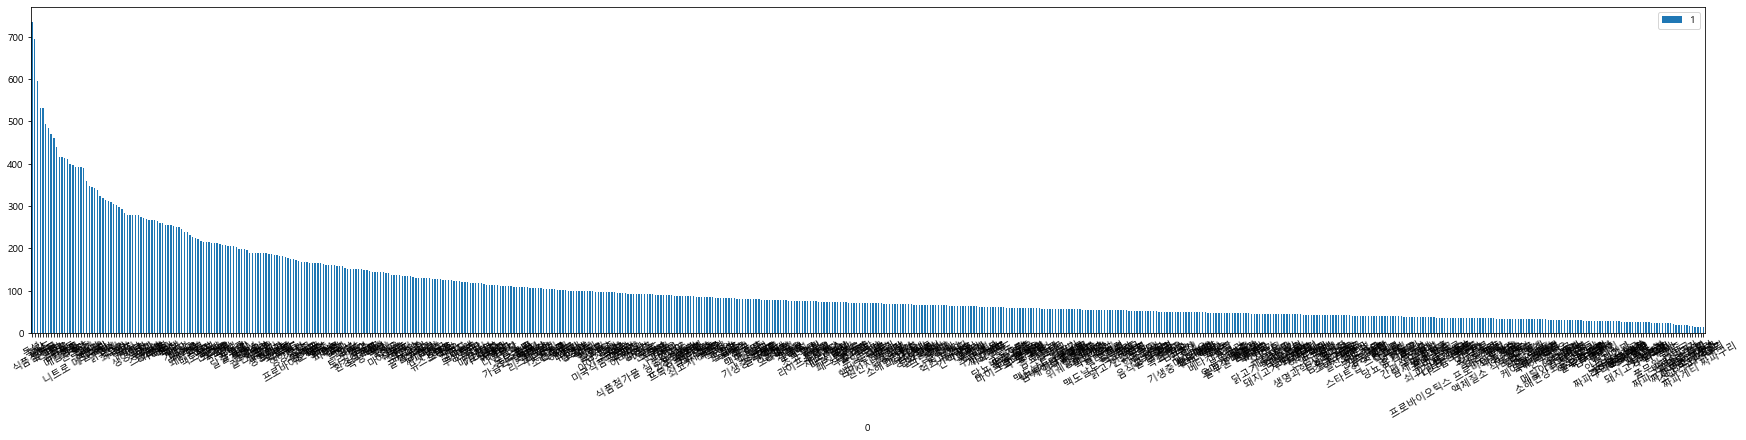

In [106]:
# 파일 저장하기
plt.rcParams['font.family']='Malgun Gothic'
result_df.set_index(0).plot(kind='bar', rot='30', figsize=(30,6))

(725, 2)

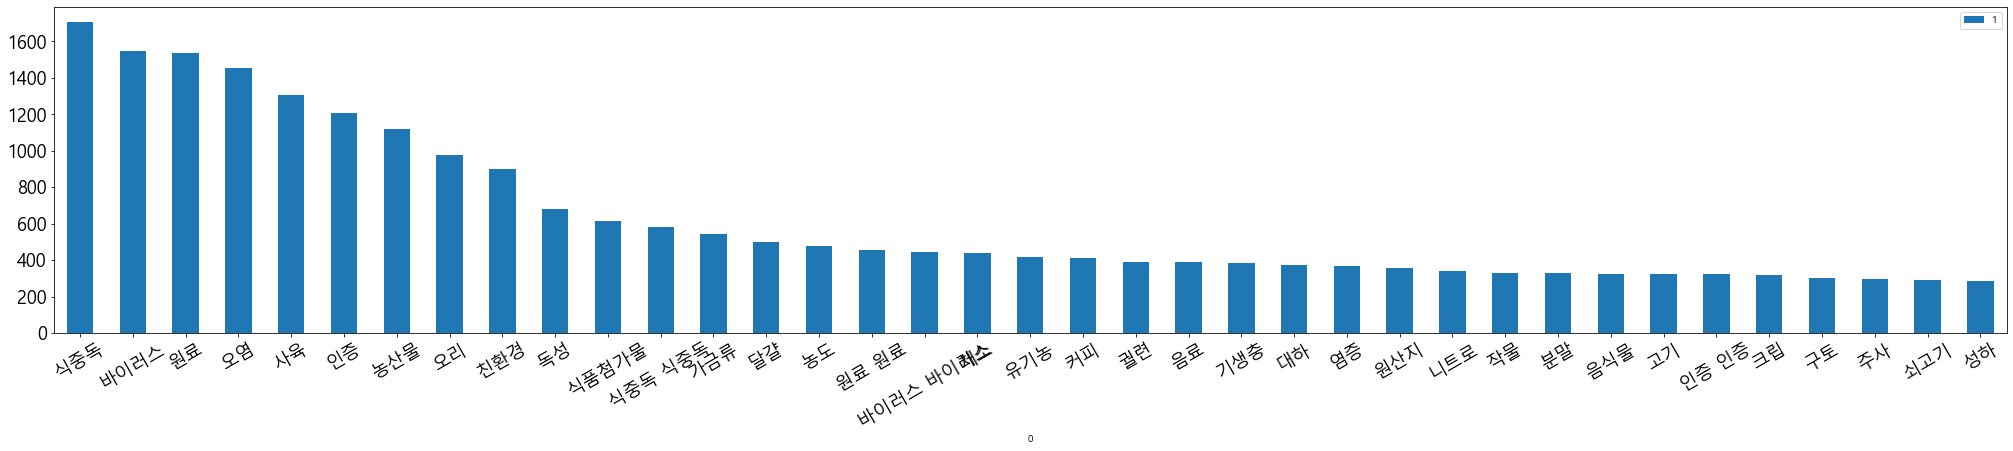

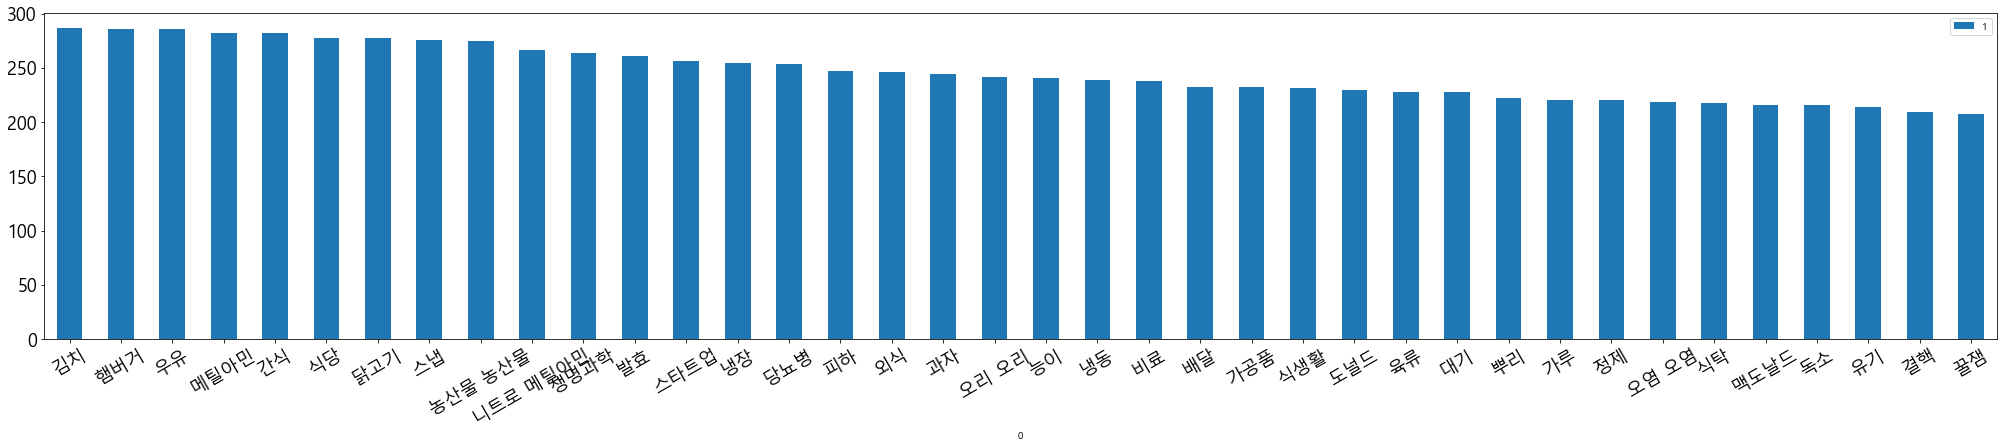

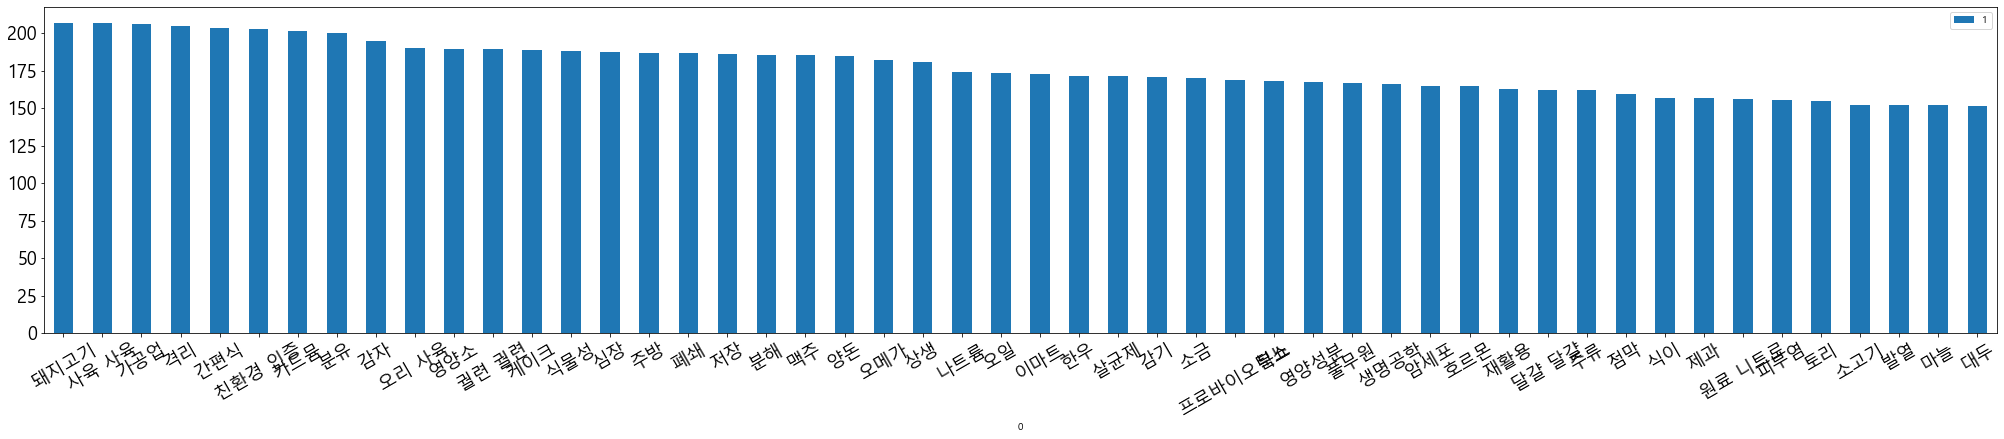

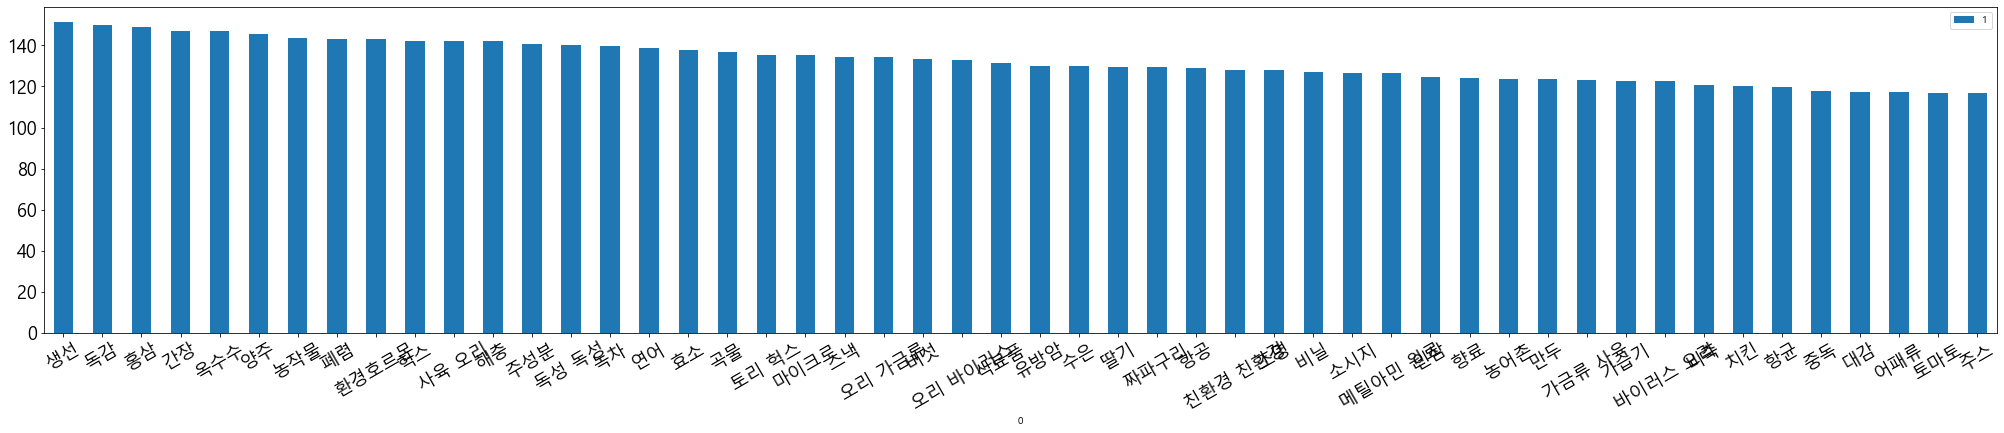

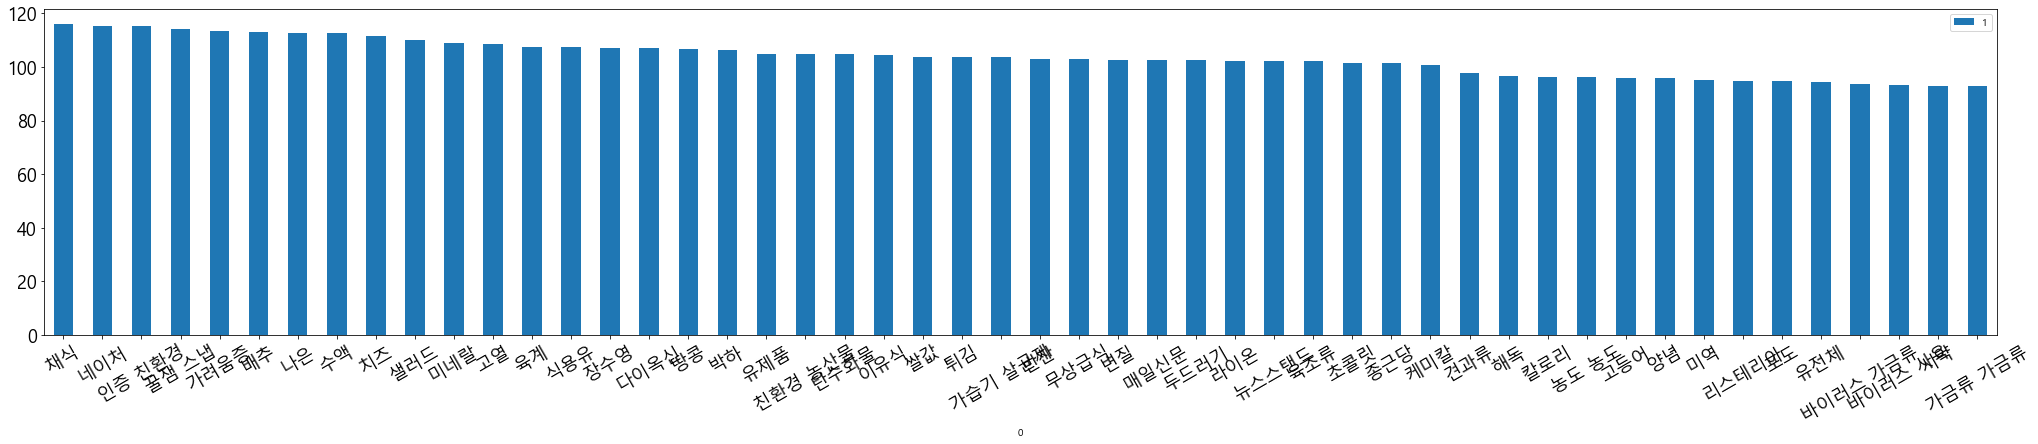

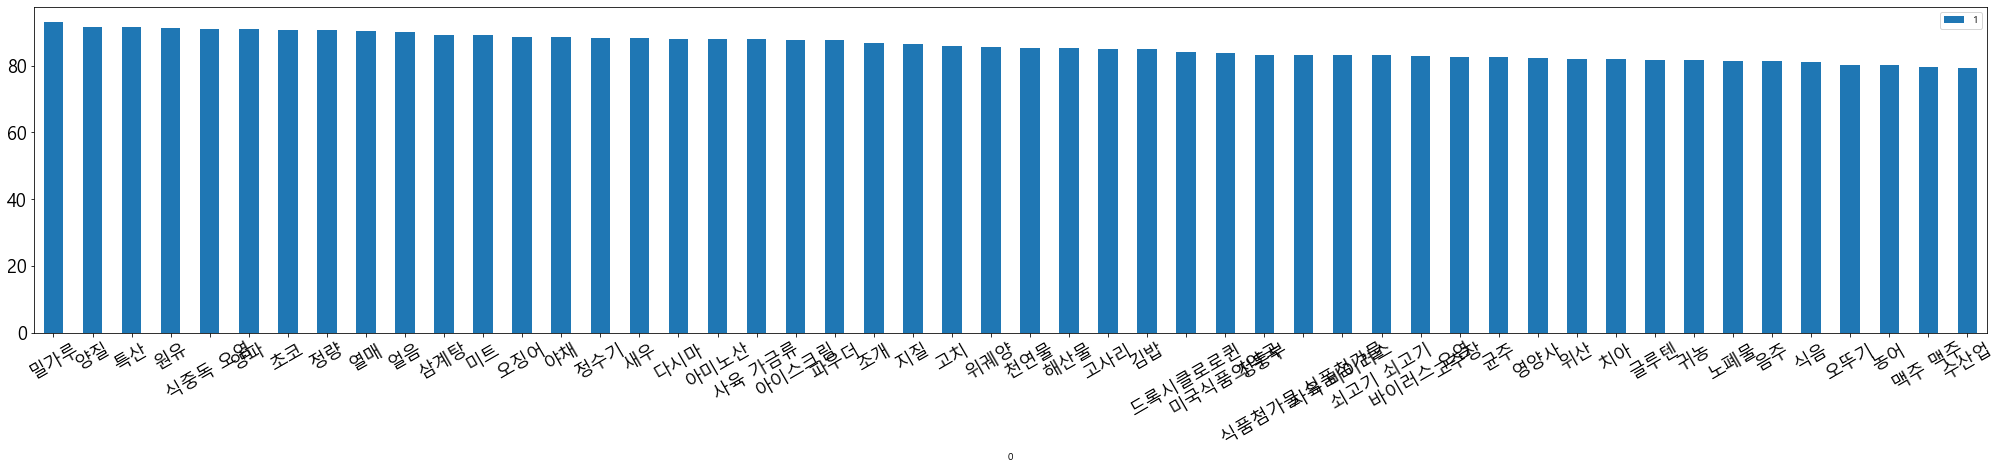

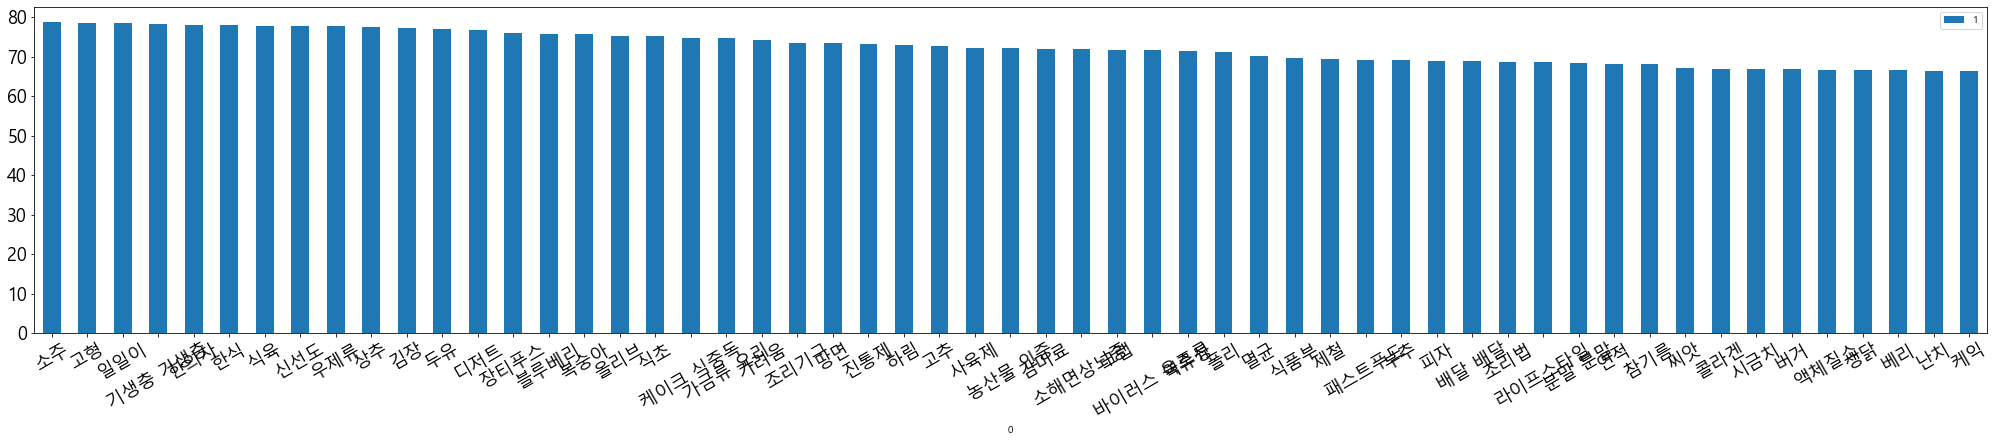

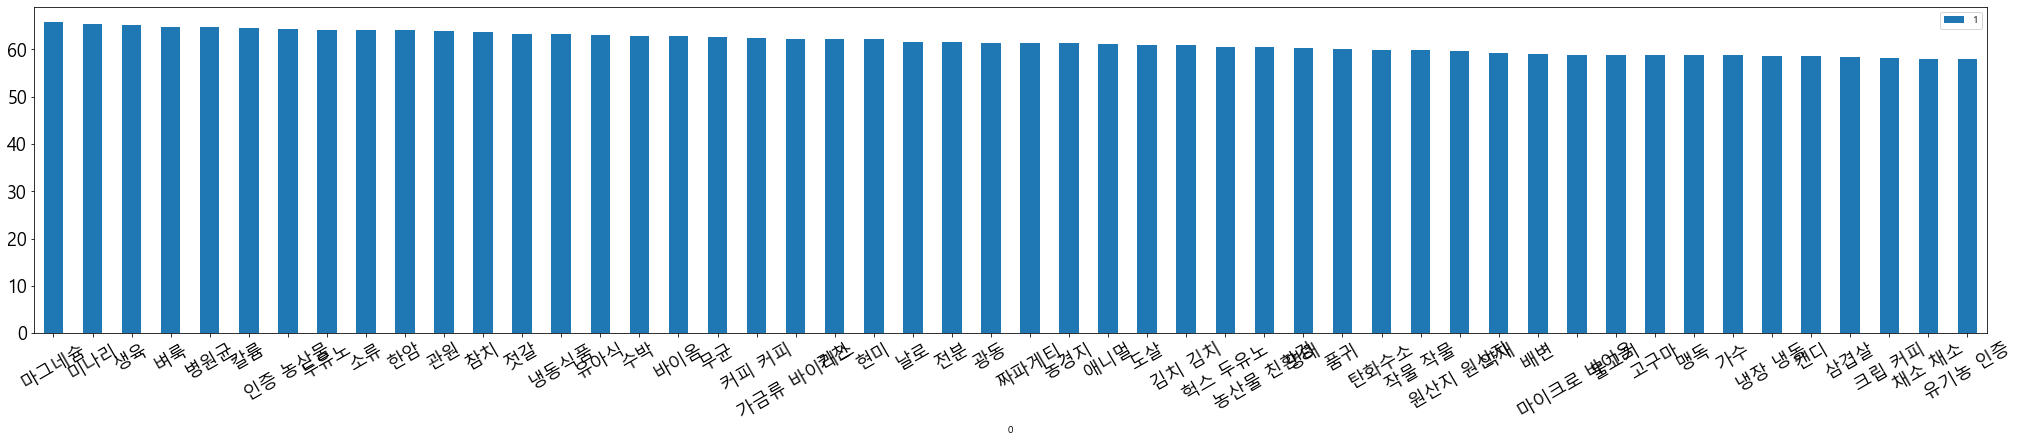

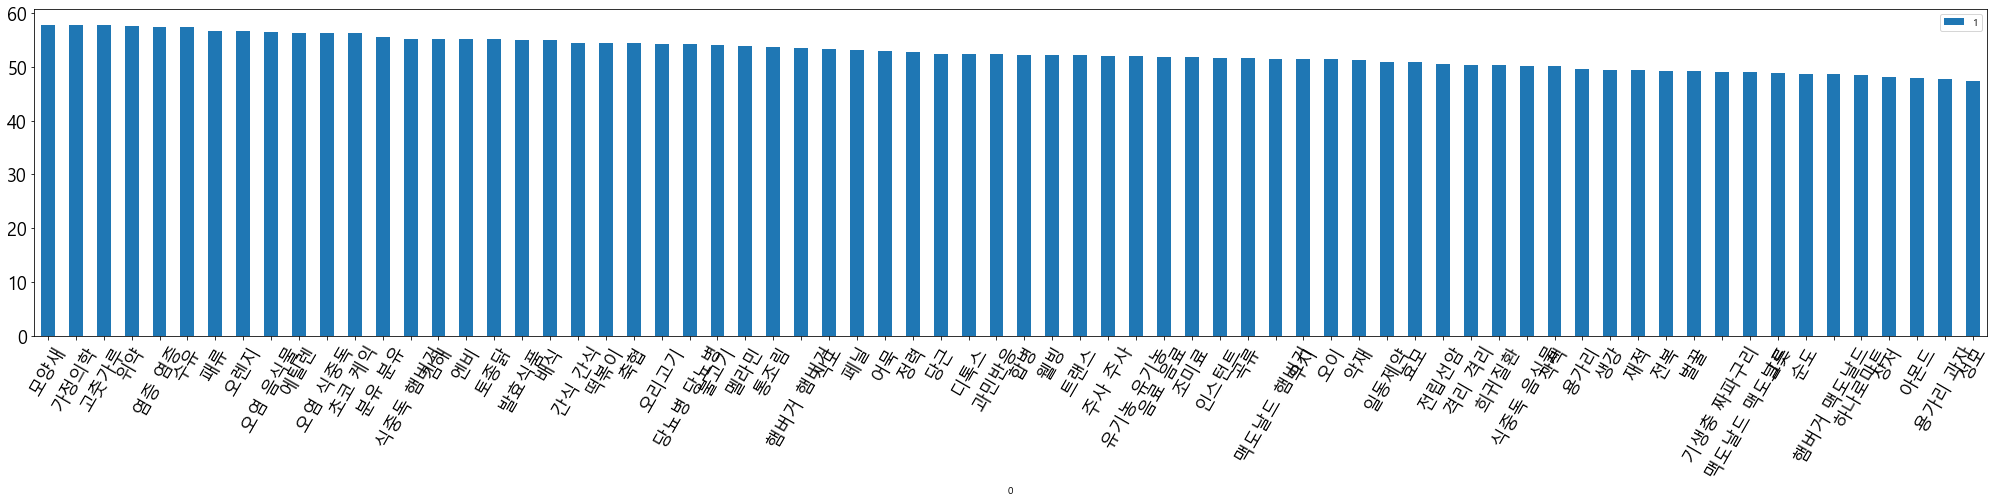

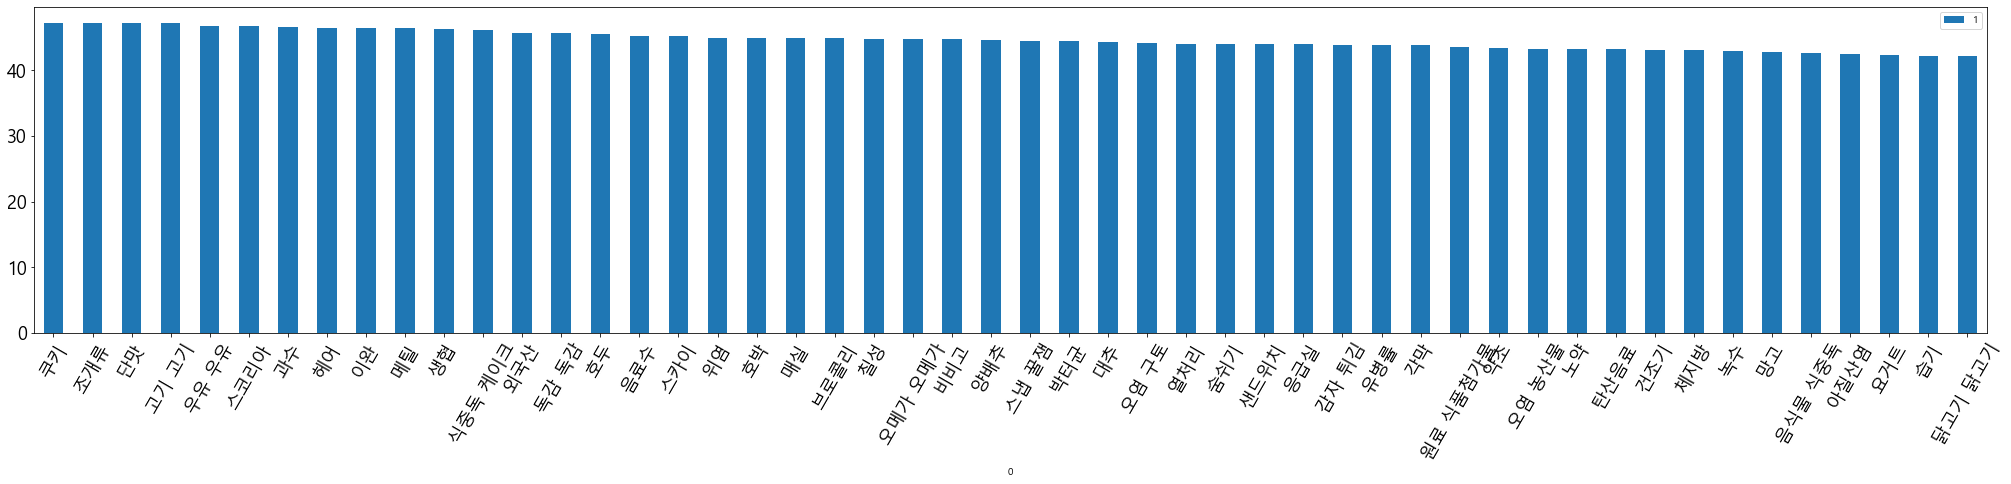

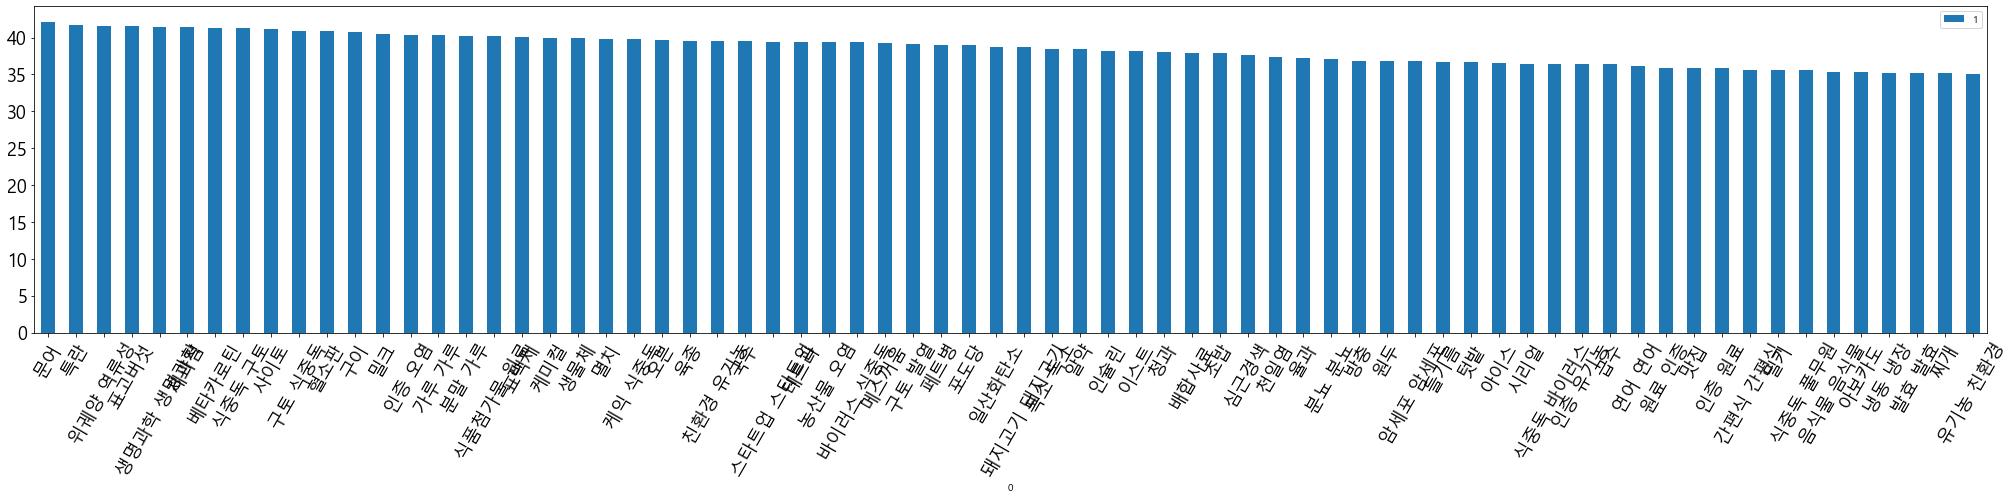

In [29]:
plt.rcParams['font.family']='Malgun Gothic'

result_df.shape
result_df.set_index(0)[0:37].plot(kind='bar', rot='30', figsize=(35,6), fontsize=18)
result_df.set_index(0)[37:75].plot(kind='bar', rot='30', figsize=(35,6), fontsize=18)
result_df.set_index(0)[75:125].plot(kind='bar', rot='30', figsize=(35,6), fontsize=18)
result_df.set_index(0)[125:175].plot(kind='bar', rot='30', figsize=(35,6), fontsize=18)
result_df.set_index(0)[175:225].plot(kind='bar', rot='30', figsize=(35,6), fontsize=18)
result_df.set_index(0)[225:275].plot(kind='bar', rot='30', figsize=(35,6), fontsize=18)
result_df.set_index(0)[275:330].plot(kind='bar', rot='30', figsize=(35,6), fontsize=18)
result_df.set_index(0)[330:380].plot(kind='bar', rot='30', figsize=(35,6), fontsize=18)
result_df.set_index(0)[380:450].plot(kind='bar', rot='60', figsize=(35,6), fontsize=18)
result_df.set_index(0)[450:500].plot(kind='bar', rot='60', figsize=(35,6), fontsize=18)
result_df.set_index(0)[500:570].plot(kind='bar', rot='60', figsize=(35,6), fontsize=18)

### <font color='green'> 4.2.2 년도별 키워드 빈도수 분석
- 연도별로 나누어서 주요 키워드 출력
- 시작년도, 끝년도 지정
- 신고일자가 없는 1401개는 데이터에서 삭제

In [30]:
df = df.reset_index()
df.dropna(axis=0, inplace=True) # 결측값이 있는 행을 삭제

In [31]:
df.년도.value_counts()

2018    56124
2019    49894
2017    33240
2020    26002
Name: 년도, dtype: int64

In [32]:
tf = df.copy()

In [33]:
stop_words[0:10]

['ha', '원주천', '정수리', '덴버', '싱가포르법인', '셀프', '남문광장', '주도적', '청춘팔팔', '국제공인시험기관']

In [34]:
result_df.head(14)[0].tolist()
new_stop_words = stop_words + result_df.head(14)[0].tolist()

['식중독',
 '바이러스',
 '원료',
 '오염',
 '사육',
 '인증',
 '농산물',
 '오리',
 '친환경',
 '독성',
 '식품첨가물',
 '식중독 식중독',
 '가금류',
 '달걀']

In [35]:
len(new_stop_words)
len(stop_words)

63186

63172

# <font color='red'> 2. Countvector()

In [38]:
# 시작년도, 끝년도 지정
from tqdm import tqdm_notebook
start_year = 2017
end_year = 2020

corpus = [""] * len(df)

result_df = pd.DataFrame()

# 녇도별 문서 추출 후 키워드 빈도수 분석

for year in tqdm_notebook(range(int(start_year),int(end_year)+1)):
    start_date = str(year) + "-01-01"
    end_date = str(year) + "-12-31"
    dt_index = (df['신고일시'] >= start_date) & (df['신고일시'] <= end_date)
    temp_df = df[dt_index]

    for i, fn in enumerate(temp_df['신고내용']) :
        corpus[i] = " ".join(twitter.nouns(fn))
        
    vect = CountVectorizer(stop_words = new_stop_words, ngram_range=(1, 2),min_df=0.005,max_df=0.5)
    X = vect.fit_transform(corpus)
    X = TfidfTransformer().fit_transform(X)
        
    count = X.toarray().sum(axis=0)
    idx = np.argsort(-count)
    count = count[idx]

    feature_name = np.array(vect.get_feature_names())[idx]

    result = list(zip(feature_name, count))
    result = pd.DataFrame(result)
    result.columns=[str(year) + ' 키워드','빈도수']
    result_df = pd.concat([result_df,result],axis=1)

    

In [39]:
result_df.to_excel(dir_path + 'naver_주제어빈도_년도별_.xlsx')

In [40]:
pd.read_excel(dir_path + 'naver_주제어빈도_년도별_.xlsx')[0:50]

,Unnamed: 0,2017 키워드,빈도수,2018 키워드,빈도수.1,2019 키워드,빈도수.2,2020 키워드,빈도수.3
0,0,쇠고기,1256.719246,궐련,1703.933095,크립,2038.431072,기생충,1735.356629
1,1,닭고기,1185.951756,채소,1523.014318,채소,1440.081398,크립,1268.779630
2,2,과자,1091.187225,농도,1503.959946,염증,1338.385753,채소,1240.470576
3,3,채소,1085.489942,커피,1200.438285,농도,1261.913540,음료,1201.830861
4,4,유기농,1065.254780,유기농,1196.129986,작물,1213.998973,유기농,1111.793948
5,5,벼룩,992.453080,작물,1194.577471,냉장,1213.891025,농도,1110.108364
6,6,커피,978.337164,니트로,1194.036123,음료,1204.205926,염증,1094.947982
7,7,농도,978.321796,대하,1066.484813,음식물,1188.133727,구토,1082.996931
8,8,햄버거,866.477809,풀무원,1024.374360,커피,1151.920576,스냅,1078.427386
9,9,구토,864.137132,구토,1006.849647,능이,1078.828830,음식물,1076.411384


In [41]:
# 인자 설정
# Random Seed 값 설정, 이값에 따라 결과 달라짐

random_seed = 1004
n_words = 50 # 상위 주제어

corpus = []

# 파일 내용 읽어서 코퍼스에 저장

for fn in tqdm_notebook(df['신고내용']) :
    text = " ".join(twitter.nouns(fn))
    corpus.append(' '.join([w for w in text.split() if len(w) > 1])) # 한 글자는 제외하고 명사추출

vect = CountVectorizer(stop_words = stop_words,ngram_range=(1, 2),min_df=0.05,max_df=0.5)
X = vect.fit_transform(corpus)
X = TfidfTransformer().fit_transform(X)

In [44]:
import scipy.sparse
scipy.sparse.save_npz(dir_path + 'sparse_matrix.npz', X)
X = scipy.sparse.load_npz(dir_path + 'sparse_matrix.npz')
X

<165260x12 sparse matrix of type '<class 'numpy.float64'>'
	with 185442 stored elements in Compressed Sparse Row format>

In [45]:
random_seed = 1004

In [46]:
dir_path

'D:/2020기본과제/naver/data/'

In [55]:
# 토픽 갯수, 리스트 타입으로 한번에 설정 [5,6,7] 등 한번에 실행도 가능

#n_topics = [3,5,7,9,11, 13, 15, 17, 19]
n_topics = [7]

for i in tqdm_notebook(n_topics):
        
    # LDA 수횅
    lda = LatentDirichletAllocation(n_components = i,learning_method="batch",random_state=random_seed)
    document_topics = lda.fit_transform(X)

    sorting = np.argsort(lda.components_, axis=1)[:,::-1]
    feature_names = np.array(vect.get_feature_names())

    # 각 문서별 주제번호 할당
    topic_list = np.argmax(document_topics,axis=1).tolist()

    topic_words = pd.DataFrame(feature_names[sorting])
    topic_words = topic_words.T
    topic_words = topic_words[:n_words]

    # 파일경로 지정
    fpath = dir_path  + "../output/lda_result_n_" + str(i) + "_" + str(random_seed) + "_"

    # 파일 저장
    document_topics = pd.DataFrame(document_topics)
    document_topics.to_excel(fpath + "document_topic.xlsx")
    topic_words.to_excel(fpath + "topic_words.xlsx")

    # 시각화 및 저장
    #pyldavis = pyLDAvis.sklearn.prepare(lda, X, vect)
   # pyLDAvis.save_html(pyldavis, fpath + str(i) + "lda.html")

In [56]:
document_topics

,0,1,2,3,4,5,6
0,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
1,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
2,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
3,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
4,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
...,...,...,...,...,...,...,...
165255,0.059322,0.059538,0.059330,0.324300,0.059322,0.059322,0.378866
165256,0.571428,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429
165257,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
165258,0.053286,0.053286,0.053296,0.053286,0.053286,0.544022,0.189540


In [57]:
topic_words

,0,1,2,3,4,5,6
0,원료,사육,농산물,오염,독성,인증,식중독
1,인증,오리,채소,바이러스,식품첨가물,친환경,채소
2,오염,바이러스,인증,인증,오염,사육,오염
3,식품첨가물,오염,오염,채소,채소,오염,바이러스
4,독성,친환경,친환경,독성,원료,농산물,원료
5,오리,채소,식중독,식중독,바이러스,원료,친환경
6,채소,인증,원료,사육,식중독,채소,인증
7,바이러스,농산물,식품첨가물,원료,인증,바이러스,독성
8,친환경,원료,사육,오리,친환경,독성,농산물
9,농산물,독성,바이러스,농산물,사육,식품첨가물,오리


In [58]:
# LDA 년도별 문서 분포 결과 출력

topic_list = pd.Series(topic_list)
result_df = pd.DataFrame()

for year in tqdm_notebook(range(int(start_year),int(end_year)+1)):
    start_date = str(year) + "-01-01"
    end_date = str(year) + "-12-31"
    dt_idx = (df['신고일시'] >= start_date) & (df['신고일시'] <= end_date)
    sub_df = df[dt_idx]
    
    dt_idx.index = topic_list.index # index 번호를 맞추기
    sub_topic_list = topic_list[dt_idx]
    
    result = []
    for t in range(max(topic_list) + 1):
        num = len(sub_topic_list[sub_topic_list==t])
        result.append(num)
    
    result = pd.Series(result,name=str(year))
    result_df = pd.concat([result_df,result],axis=1)            


# 비율로 만들기
result_df = result_df.T.apply(lambda x: x / x.sum(),axis=1)

In [59]:
result_df

,0,1,2,3,4,5,6
2017,0.321721,0.184717,0.027677,0.147714,0.131227,0.114741,0.072202
2018,0.423776,0.119058,0.056910,0.124510,0.064678,0.086630,0.124439
2019,0.445384,0.073917,0.075600,0.128432,0.073356,0.095482,0.107829
2020,0.408738,0.049304,0.049919,0.191985,0.046381,0.104300,0.149373


Text(0.1608604091456077, 0.0, '32.2')

Text(0.21188796236903998, 1.0, '42.4')

Text(0.2226921072674069, 2.0, '44.5')

Text(0.20436889470040767, 3.0, '40.9')

Text(0.4140794223826715, 0.0, '18.5')

Text(0.48330482503029004, 1.0, '11.9')

Text(0.4823425662404297, 2.0, '7.4')

Text(0.4333897392508269, 3.0, '4.9')

Text(0.5202767749699158, 0.0, '2.8')

Text(0.5712885752975554, 1.0, '5.7')

Text(0.5571010542349781, 2.0, '7.6')

Text(0.4830013075917237, 3.0, '5.0')

Text(0.6079723225030084, 0.0, '14.8')

Text(0.6619984320433325, 1.0, '12.5')

Text(0.6591173287369223, 2.0, '12.8')

Text(0.603953542035228, 3.0, '19.2')

Text(0.7474428399518651, 0.0, '13.1')

Text(0.7565925450787542, 1.0, '6.5')

Text(0.7600112237944442, 2.0, '7.3')

Text(0.7231366817937082, 3.0, '4.6')

Text(0.8704271961492178, 0.0, '11.5')

Text(0.8322464542798089, 1.0, '8.7')

Text(0.8444301920070549, 2.0, '9.5')

Text(0.7984770402276747, 3.0, '10.4')

Text(0.963898916967509, 0.0, '7.2')

Text(0.9377806286080821, 1.0, '12.4')

Text(0.9460857016875777, 2.0, '10.8')

Text(0.9253134374278902, 3.0, '14.9')

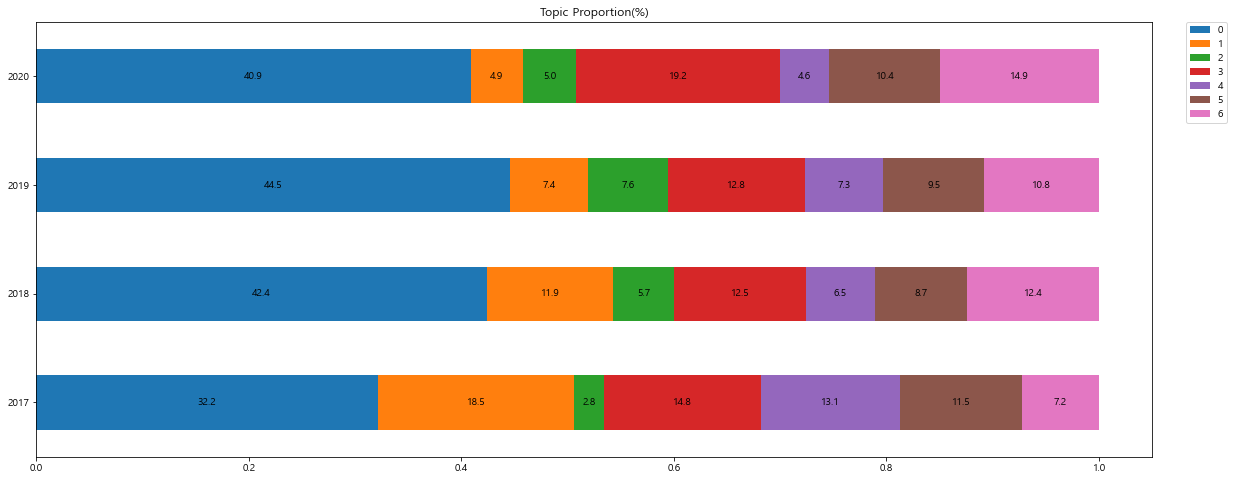

In [60]:
ax = result_df.plot.barh(stacked=True,legend=False,figsize=(20, 8), title="Topic Proportion(%)")
ax.legend(bbox_to_anchor=(1.03, 1),loc=2, borderaxespad=0.)

for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%.1f"%(width*100), xy=(left+width/2, bottom+height/2), ha='center', va='center')

In [53]:
from wordcloud import WordCloud, STOPWORDS

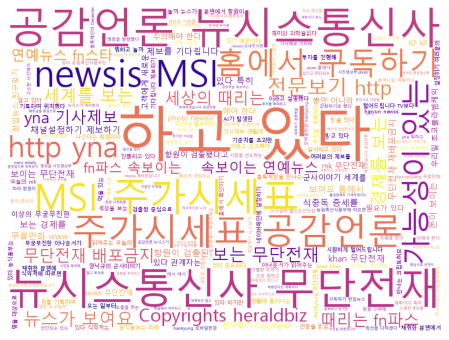

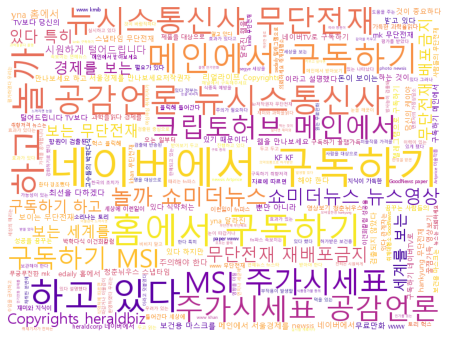

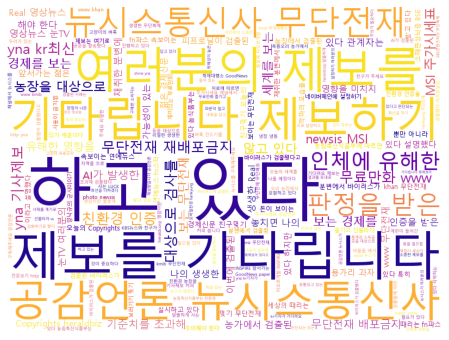

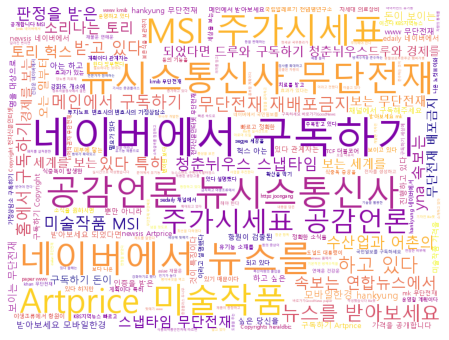

In [54]:
def displayWordCloud(data = None):
    wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', 
                          stopwords = stop_words,
                          background_color = 'white',
                          colormap = "plasma",
                          width = 800, height = 600).generate(data)
    plt.figure(figsize = (8 , 6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

for year in df.년도.value_counts().index :
        displayWordCloud(' '.join([i for i in df[df['년도'] == year]['신고내용']]))

In [52]:
lda # Model attributes

LatentDirichletAllocation(n_components=7, random_state=1004)

In [53]:
from konlpy.utils import pprint
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(X))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(X))

# See model parameters
pprint(lda.get_params())

Log Likelihood:  -829893.3946021644
Perplexity:  45.33604627503824
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 7,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 1004,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [54]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [3,5,7,9,11], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
%time model.fit(X)

Wall time: 2h 10min 18s


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [3, 5, 7, 9, 11]})

In [55]:
model.cv_results_["mean_test_score"]
print(model.best_score_)
print(model.best_params_)

array([-154515.05030305, -162188.37854159, -170219.12429313,
       -173409.05560326, -178902.72317394, -154854.24179893,
       -161979.72574857, -170042.74093205, -175253.64394568,
       -179760.28412754, -154524.20625414, -162764.14260015,
       -169562.56273872, -174895.02204002, -179298.62486355])

-154515.05030305224
{'learning_decay': 0.5, 'n_components': 3}


In [56]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3}
Best Log Likelihood Score:  -154515.05030305224
Model Perplexity:  36.285854557415846


In [57]:
pd.DataFrame(model.cv_results_)[['param_learning_decay', 'param_n_components', 'mean_test_score']].sort_values(by ='mean_test_score', ascending=False)

,param_learning_decay,param_n_components,mean_test_score
0,0.5,3,-154515.050303
10,0.9,3,-154524.206254
5,0.7,3,-154854.241799
6,0.7,5,-161979.725749
1,0.5,5,-162188.378542
11,0.9,5,-162764.142600
12,0.9,7,-169562.562739
7,0.7,7,-170042.740932
2,0.5,7,-170219.124293
3,0.5,9,-173409.055603
